# **Autoencoder**

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import sys
sys.path.append('../')

from src.autoencoder.autoencoder import ConvAutoencoder

In [59]:
encoder_channels = [3, 4, 16, 32, 64]
decoder_channels = [64, 32, 16, 4, 3]
autoencoder = ConvAutoencoder(encoder_channels, decoder_channels)

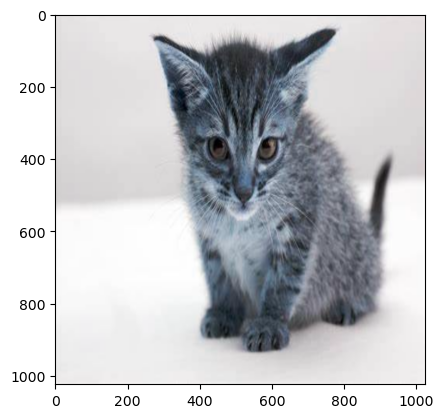

In [60]:
# read pussy.jpg
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('../data/cat.jpg')
img = cv2.resize(img, (1024, 1024))
plt.imshow(img)
plt.show()

In [61]:
# convert to tensor
import torch
from torchvision import transforms

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = transforms.ToTensor()(img)
img

tensor([[[0.9490, 0.9451, 0.9412,  ..., 0.9333, 0.9333, 0.9333],
         [0.9490, 0.9451, 0.9412,  ..., 0.9333, 0.9333, 0.9333],
         [0.9451, 0.9412, 0.9373,  ..., 0.9294, 0.9294, 0.9294],
         ...,
         [0.9255, 0.9294, 0.9373,  ..., 0.9569, 0.9529, 0.9490],
         [0.9294, 0.9333, 0.9412,  ..., 0.9569, 0.9490, 0.9490],
         [0.9294, 0.9333, 0.9412,  ..., 0.9569, 0.9490, 0.9490]],

        [[0.9490, 0.9451, 0.9412,  ..., 0.9294, 0.9294, 0.9294],
         [0.9490, 0.9451, 0.9412,  ..., 0.9294, 0.9294, 0.9294],
         [0.9451, 0.9412, 0.9373,  ..., 0.9255, 0.9255, 0.9255],
         ...,
         [0.9255, 0.9294, 0.9373,  ..., 0.9569, 0.9529, 0.9490],
         [0.9294, 0.9333, 0.9412,  ..., 0.9569, 0.9490, 0.9490],
         [0.9294, 0.9333, 0.9412,  ..., 0.9569, 0.9490, 0.9490]],

        [[0.9569, 0.9529, 0.9490,  ..., 0.9529, 0.9529, 0.9529],
         [0.9569, 0.9529, 0.9490,  ..., 0.9529, 0.9529, 0.9529],
         [0.9529, 0.9490, 0.9451,  ..., 0.9490, 0.9490, 0.

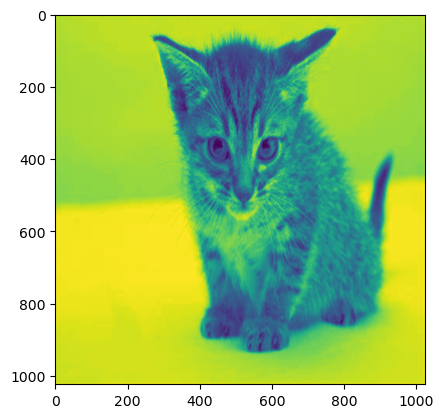

In [62]:
# show image
plt.imshow(img[0])

In [63]:
# Pass the image through the autoencoder
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 1024, 1024])

In [64]:
img_encoded = autoencoder(img)

Sequential(
  (enc_conv0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu0): ReLU(inplace=True)
  (enc_conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu1): ReLU(inplace=True)
  (enc_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu2): ReLU(inplace=True)
  (enc_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu3): ReLU(inplace=True)
)
Sequential(
  (dec_convtrans0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_relu0): ReLU(inplace=True)
  (dec_convtrans1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_relu1): ReLU(inplace=True)
  (dec_convtrans2): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_relu2): ReLU(inplace=True)
  (dec_convtrans3): ConvTranspose2d(4, 3, kernel_size=(3, 3), 

In [65]:
img_encoded.shape

torch.Size([1, 3, 1024, 1024])

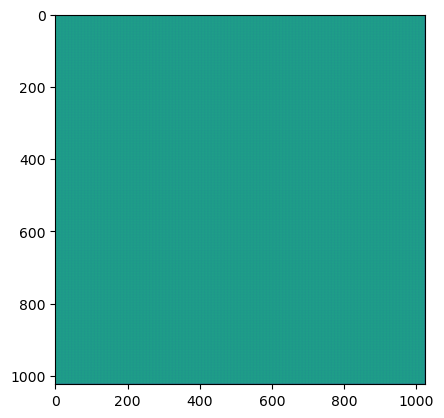

In [66]:
plt.imshow(img_encoded[0][0].detach().numpy())
plt.show()